Import Necessary Modules

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder

Initialize Variables

In [12]:
number_train_images = 60000
number_test_images = 10000
total_pixels=784
column_names=['labels'] + [f'pixel{i}' for i in range(total_pixels)]

Create Paths for Data

In [13]:
def getPath(relative_path):
    # Create a Path object with the relative path and resolve it to an absolute path
    return str(Path.cwd().joinpath(relative_path).resolve())

In [14]:
mnist_train_ubyte_images = getPath("data/train-images-idx3-ubyte")
mnist_train_ubyte_labels = getPath("data/train-labels-idx1-ubyte")
mnist_test_ubyte_images = getPath("data/t10k-images-idx3-ubyte")
mnist_test_ubyte_labels = getPath("data/t10k-labels-idx1-ubyte")
train_csv_path = getPath("mnist_train.csv")
test_csv_path = getPath("mnist_test.csv")

Convert Data to CSV

In [15]:
def mnist_to_csv(imgs, labels, csvPath, n, total_pixels):
    # Read image and label dat
    imgData = open(imgs, 'rb')
    labelData = open(labels, 'rb')
    # Write CSV file
    csvData = open(csvPath, 'w')

    # Skip header information and write to images list
    imgData.read(16)
    labelData.read(8)
    images = []

    # Loop through n and append pixel data to images list
    for i in range(n):
        # Capture label in image list and loop through total pixels count to add corresponding data to image
        image = [ord(labelData.read(1))]
        for j in range(total_pixels):
            image.append(ord(imgData.read(1)))
        # Append image list to images list
        images.append(image)

    # Write image data to CSV file by iterating through image list and separating row data by comma
    for image in images:
        csvData.write(','.join(str(pix) for pix in image) + '\n')

    # Close files
    imgData.close()
    labelData.close()
    csvData.close()

In [16]:
mnist_to_csv(mnist_train_ubyte_images, mnist_train_ubyte_labels, train_csv_path, number_train_images, total_pixels)
mnist_to_csv(mnist_test_ubyte_images, mnist_test_ubyte_labels, test_csv_path, number_test_images, total_pixels)

Use Pandas to Pull Data into DataFrame

In [17]:
df_train = pd.read_csv(train_csv_path, header=None, names=column_names)
df_test = pd.read_csv(test_csv_path, header=None, names=column_names)

In [18]:
train_images = df_train.drop('labels', axis=1).values
train_labels = df_train['labels'].values
test_images = df_test.drop('labels', axis=1).values
test_labels = df_test['labels'].values

Create a NeuralNetwork Class

In [19]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_functions, learning_rate=0.0001):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.activation_functions = activation_functions
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(y, x) * np.sqrt(2 / x) for x, y in zip(self.layers[:-1], self.layers[1:])]
        self.biases = [np.zeros((y, 1)) for y in self.layers[1:]]
        self.loss_history = []
        self.accuracy_history = []

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def leaky_relu(z):
        return np.where(z > 0, z, z * 0.01)

    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def activation_derivative(self, activation, function):
        if function == self.relu or function.__name__ == 'relu':
            return np.where(activation > 0, 1, 0)
        elif function == self.leaky_relu or function.__name__ == 'leaky_relu':
            return np.where(activation > 0, 1, 0.01)
        elif function == self.softmax or function.__name__ == 'softmax':
            return np.ones_like(activation)
        else:
            raise ValueError("Unknown activation function")

    def forward_propagation(self, x):
        activations = [x]
        z_values = []
        for weight, bias, activation_func in zip(self.weights, self.biases, self.activation_functions):
            z = np.dot(weight, activations[-1]) + bias
            z_values.append(z)
            activations.append(activation_func(z))
        return activations, z_values

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def backward_propagation(self, y_true, activations, weights, biases):
        weight_grads = [None] * len(weights)
        bias_grads = [None] * len(biases)
        delta = activations[-1] - y_true

        for i in reversed(range(len(weights))):
            weight_grads[i] = np.dot(delta, activations[i].T)
            bias_grads[i] = np.sum(delta, axis=1, keepdims=True)
            if i != 0:
                delta = np.dot(weights[i].T, delta) * self.activation_derivative(activations[i], self.activation_functions[i])

        return weight_grads, bias_grads

    def update_parameters(self, weight_grads, bias_grads, clip_value=1.0):
        for i in range(len(self.weights)):
            weight_grads[i] = np.clip(weight_grads[i], -clip_value, clip_value)
            bias_grads[i] = np.clip(bias_grads[i], -clip_value, clip_value)
            self.weights[i] -= self.learning_rate * weight_grads[i]
            self.biases[i] -= self.learning_rate * bias_grads[i]
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_pred == y_true)

    def train(self, x_train, y_train, epochs):
        for epoch in range(epochs):
            activations, _ = self.forward_propagation(x_train)
            loss = self.compute_loss(y_train, activations[-1])
            weight_grads, bias_grads = self.backward_propagation(y_train, activations, self.weights, self.biases)
            self.update_parameters(weight_grads, bias_grads)
            accuracy = self.accuracy(np.argmax(y_train, axis=0), np.argmax(activations[-1], axis=0))
            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)
            if epoch % 10 == 0:
                print(f'Epoch {epoch} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    def predict(self, x):
        activations, _ = self.forward_propagation(x)
        return np.argmax(activations[-1], axis=0)

    def plot_metrics(self):
        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(self.accuracy_history, label='Training Accuracy', color='green')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Specify Parameters and Train Neural Network

Epoch 0 - Loss: 2.5184, Accuracy: 0.0923
Epoch 10 - Loss: 2.3882, Accuracy: 0.0925
Epoch 20 - Loss: 2.3013, Accuracy: 0.1040
Epoch 30 - Loss: 2.2373, Accuracy: 0.1310
Epoch 40 - Loss: 2.1822, Accuracy: 0.1686
Epoch 50 - Loss: 2.1291, Accuracy: 0.2104
Epoch 60 - Loss: 2.0753, Accuracy: 0.2500
Epoch 70 - Loss: 2.0200, Accuracy: 0.2897
Epoch 80 - Loss: 1.9635, Accuracy: 0.3264
Epoch 90 - Loss: 1.9058, Accuracy: 0.3611
Epoch 100 - Loss: 1.8473, Accuracy: 0.3943
Epoch 110 - Loss: 1.7888, Accuracy: 0.4279
Epoch 120 - Loss: 1.7309, Accuracy: 0.4594
Epoch 130 - Loss: 1.6734, Accuracy: 0.4900
Epoch 140 - Loss: 1.6169, Accuracy: 0.5202
Epoch 150 - Loss: 1.5617, Accuracy: 0.5488
Epoch 160 - Loss: 1.5081, Accuracy: 0.5775
Epoch 170 - Loss: 1.4558, Accuracy: 0.6045
Epoch 180 - Loss: 1.4048, Accuracy: 0.6302
Epoch 190 - Loss: 1.3556, Accuracy: 0.6550
Epoch 200 - Loss: 1.3079, Accuracy: 0.6781
Epoch 210 - Loss: 1.2620, Accuracy: 0.6970
Epoch 220 - Loss: 1.2181, Accuracy: 0.7135
Epoch 230 - Loss: 1.17

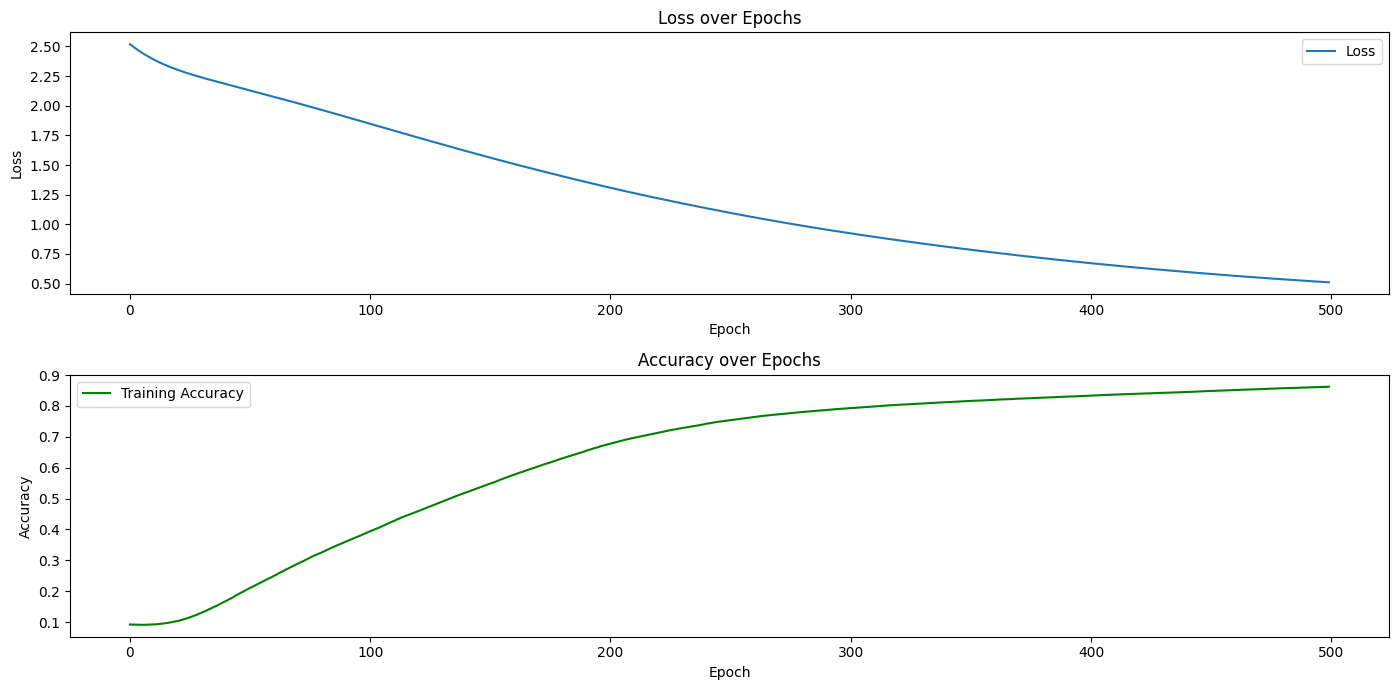

0.8682

In [20]:
train_epochs = 500
subset_size = 60000
subset_indices = np.random.choice(train_images.shape[0], subset_size, replace=False)
x_train_subset = train_images[subset_indices].reshape(subset_size, -1).T / 255.0
y_train_subset = train_labels[subset_indices]

encoder = OneHotEncoder(sparse=False)
y_train_subset_encoded = encoder.fit_transform(y_train_subset.reshape(-1, 1)).T
x_test = test_images.reshape(test_images.shape[0], -1).T / 255.0
y_test_encoded = encoder.transform(test_labels.reshape(-1, 1)).T

nn = NeuralNetwork(
    input_size=784, 
    hidden_layers=[64, 32],
    output_size=10,
    activation_functions=[NeuralNetwork.leaky_relu, NeuralNetwork.leaky_relu, NeuralNetwork.softmax],
    learning_rate=0.0001
)

nn.train(x_train_subset, y_train_subset_encoded, epochs=train_epochs)
nn.plot_metrics()

y_pred_test = nn.predict(x_test)
test_accuracy = nn.accuracy(np.argmax(y_test_encoded, axis=0), y_pred_test)

test_accuracy